# GROUP 02 - HOMEWORK 4

In [1]:
#We import libraries needed
import functions as fn
import pandas as pd
import json
import numpy as np
from matplotlib import pyplot as plt
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from nltk.corpus import stopwords
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
% matplotlib inline

## Web scraping

As our first task, we were asked to retrieve the data from the [immobiliare.it](https://www.immobiliare.it/vendita-case/roma/?pag=1) page. We had to web-scrape the page and we have done that using BeautifulSoup. We had to retrieve(for each announcement) title, description, price, number of rooms, area, number of baths and number of the floor. For every research page we were obliged to retrieve the link of every single apartment and then proceed with the scraping part. In the while loop we also introduced a **try-except** because if an apartment was missing even one of the previous information we did not take it into account.

The documents that were retrieved were numero because out of the 10600 we searched through approx 3500 were missing an info.

P.S. We did **not** consider any apartment that did not have a final prize. In fact, some of them were using action-prizes and we thought that this could have affected our analysis. 


In [13]:
fn.web_scrap()
#We stored the dataframe in an external "pickle" file, which was easier to handle. 
#When needed, we loaded it back using the load function

In [2]:
fn.save() 

## Data Cleaning

As described in the following chuncks of code, data was cleaned in different levels. 

At the end of the process, just 7852 apartments survived.

In [2]:
df = fn.clean_information()  #  In this function we load the file with all the docs

In [3]:
fn.clean_description()

In [4]:
fn.create_vocabulary()

In [5]:
fn.idf()

# Clustering

**Clustering** is the process of dividing the datasets into groups, consisting of similar data-points. <br> <br> - Points in the same group are as similar as possible; <br> - Points in different group are as dissimilar as possible. <br> <br> **What is K-Means clustering?** K-Means is a clustering algorithm whose main goal is to group similar elements or data points into a cluster. <br> N.B. K represents number of clusters. <br> <br> **1. Information** This step consists in clustering the first matrix. The first matrix will have this format: $m_{ij} = value$ where $i \in \{announcement_1, ..., announcement_n\}$ and $j \in \{price, locali, superficie, bagni, piano \}$. n is the number of the announcements.

In [6]:
# To create the first matrix from the dataframe we consider only the following columns. 
# The lenght of our dataframe will be n (number of announcements).
df = df[['Prices', 'Locals', 'Area', 'Bath', 'Floor']]
df

,Prices,Locals,Area,Bath,Floor
0,360000,4,169,2,0
1,215000,2,84,1,0
2,530000,4,120,2,1
3,210000,3,90,2,3
4,870000,5,220,3,1
5,250000,4,160,2,2
6,385000,3,85,1,5
7,390000,4,110,1,4
8,195000,2,50,1,0
9,319000,3,110,2,1


In [7]:
# Now we create our first matrix
m = df.values
m = m.astype(np.int) # transform in values array

#### Elbow Method and K-Means ++ Clustering

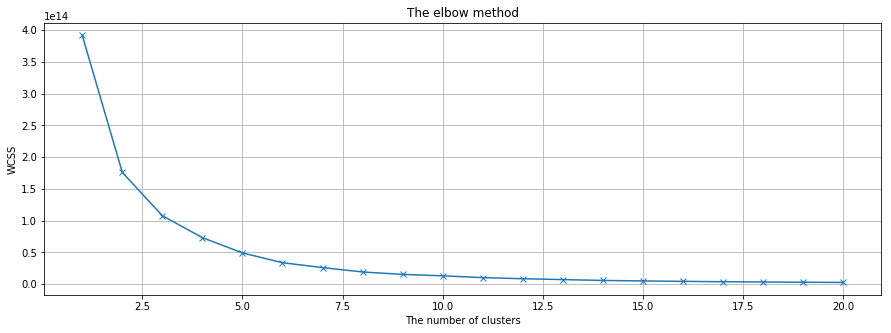

In [9]:
wcss_m = fn.elbow_method(m, 'i')
fig = plt.figure(figsize=(15, 5))
plt.plot(range(1, 21), wcss_m, marker = "x")
plt.grid(True)
plt.title('The elbow method')
plt.xlabel('The number of clusters')
plt.ylabel('WCSS')
plt.show()

The *elbow diagram* shows that the curve decreases significantly from 3 to 5. So, optimal number of clusters could be either 4 or 5. We decided to get *k = 4* as number of optimum clusters. Infact, k = 4 is the value in which the curve stops sensitively decreasing. <br> Then, we find the *labels*: each announcement corresponds to cluster 0, 1, 2 or 3.

In [10]:
# Based on the above Elbow method, we get 4 as number of optimum clusters
kmeans_m = KMeans(n_clusters=4, random_state=0).fit(m)
labels1 = kmeans_m.labels_

**2. Information** The second matrix will have this format: $m_{ij} = tfIdf_{ij}$ where $i \in \{announcement_1, ..., announcement_n\}$ and $j \in \{word_1, ...,word_m\}$. n is the number of the announcements and m is the cardinality of the vocabulary.

In [11]:
# replace NaN with zeros
tfi_df = fn.index_to_dataframe()
tfi_df = tfi_df.fillna(value = 0)
mw = tfi_df.values

#### Elbow Method and K-Means ++ Clustering

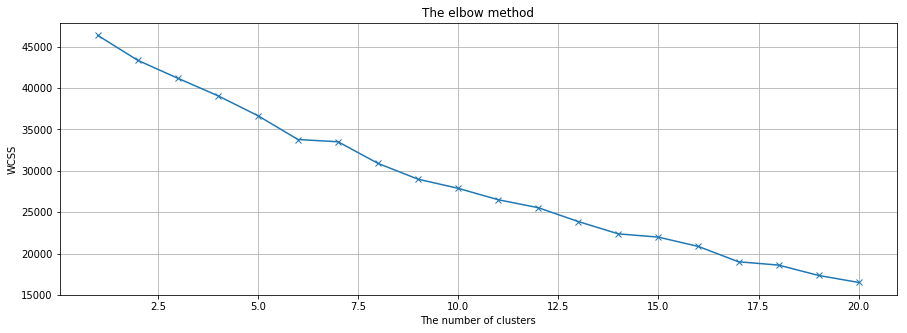

In [12]:
wcss_mw = fn.elbow_method(mw, 'd')
fig = plt.figure(figsize=(15, 5))
plt.plot(range(1, 21), wcss_mw, marker = "x")
plt.grid(True)
plt.title('The elbow method')
plt.xlabel('The number of clusters')
plt.ylabel('WCSS')
plt.show()

In this second plot we have noticed that, if we increase the range, the curve doesn't stop sensitively decreasing. So, the optimal number of clusters (k) for the second matrix would be too high, so it would not make sense have so many clusters.
<br> We decide to take k = 4 clusters (like the first matrix) in order to compare each of them in pairs with the Information clusters. <br> Then, we find the labels of Matrix 2.

In [13]:
kmeans_mw = KMeans(n_clusters=4, random_state=0).fit(mw)

labels2 = kmeans_mw.labels_


### Jaccard Similarity - Find similar clusters

To measure the similarity between each clusters couple of two different matrices, we use the **Jaccard Similarity**. The *Jaccard index*, also known as Intersection over Union, is a statistic used for comparing the similarity and diversity of sample sets.

First of all, we have to create two dictionaries:
- d1 of Matrix 1
- d2 of Matrix 2


Each cluster key contains the respective announcements.

In [14]:
d1, d2 = fn.get_dictionaries(labels1, labels2)

We apply jaccard similarity to all possible combination of cluster couples.

$$jaccard-similarity=\frac{d1\cap{d2}}{d1\cup{d2}}$$

In [15]:
js = []
for i in d1.values():
    for j in d2.values():
        res = fn.jaccard(i, j)
        js.append(res)      


We obtained 16 different jaccard similarity values. Infact, we have 4 clusters for each matrix, so, 16 combinations.

Now, we transform jaccard similarity values list to a dataframe: **dfjs**.

In [16]:
dfjs = pd.DataFrame(js, columns = ["Jaccard"])

In this step, we have to group the announcements of the two matrix to their respective couple clusters.

In [17]:
ja = []
for i in d1.values():
    for j in d2.values():
        ann = set(i + j) # with set we remove all duplicates
        ja.append(list(ann))

We transform the announcements lists to a dataframe: **dfja**.

In [18]:
dfja = pd.DataFrame({'Announcements':ja})

Now, we combine the two dataframes: *dfjs* and *dfja*. The new dataframe is **dft** and represents 16 jaccard similarity values with their respective announcements of both the matrices.

In [19]:
dft = dfjs.combine_first(dfja)

We return the 3 most similar couples of clusters. We sort in descendant way on Jaccard column of dft. Then, we print the 3 most high jaccard similarity values.

In [20]:
dft = dft.sort_values(by=["Jaccard"], ascending=False)

# index of rows from zero to len(df)
dft.index = np.arange(0,len(dft))

dfthree = dft.head(3)
dfthree

,Announcements,Jaccard
0,"[0, 2, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, ...",0.008193
1,"[0, 6147, 4, 6149, 5, 7, 8, 4105, 9, 2059, 206...",0.007673
2,"[0, 1, 3, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, ...",0.006753


Before creating the WordClouds for the 3-most similar couples of clusters (*dfthree*), we have performed the following steps to each row of *dfthree*:
- take all the descriptions from the original dataframe *df*;
- link the descriptions to their respective announcements index (left column - Announcements - of dfthree dataframe);
- clean the descriptions (remove whitespaces, numbers, punctuation, Euro symbol);
- create three descriptions lists: wc1, wc2 and wc3.

*See all these steps in functions.py file*

In [19]:
wc1,wc2,wc3 = fn.get_word_clouds(dfthree)

### Word cloud of house descriptions

With these three outputs we have to create a **WordCloud** for each couple of clusters. The words that will be represented are those extracted from the description of the houses that are in the relative couple.

Now, we want to create an **house mask** filled with lots of words in different sizes, which represent the frequency or the importance of each word.

In [21]:
house_mask = np.array(Image.open("house.png"))

We create three dataframes **text1**, **text2** and **text3** of all descriptions in *wc1*, *wc2*, *wc3*.

#### First WordCloud

There are 58423 words in the combination of all review.


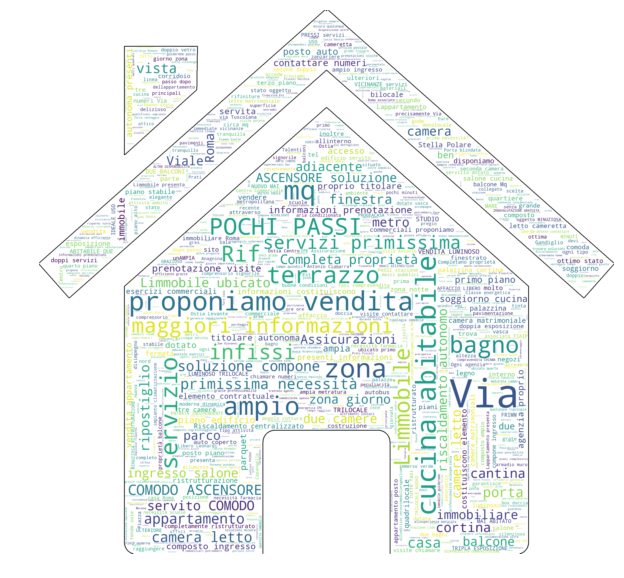

In [30]:
stop_words = set(stopwords.words('italian'))

text1 = pd.DataFrame(wc1, columns = ['First JS Descriptions'])
res1 = " ".join(review for review in text1['First JS Descriptions'])
print("There are {} words in the combination of all review.".format(len(res1)))

transformed_house_mask1 = np.ndarray((house_mask.shape[0], house_mask.shape[1]), np.int32)

for i in range(len(house_mask)):
    transformed_house_mask1[i] = list(map(fn.transform_format, house_mask[i]))

transformed_house_mask1
wc1 = WordCloud(background_color="white", max_words=1000, mask=transformed_house_mask1,
               stopwords=stop_words, contour_width=3, contour_color='black')

wc1.generate(res1)

plt.figure(figsize=[20,10])
plt.imshow(wc1, interpolation='bilinear')
plt.axis("off")
plt.show()

#### Second WordCloud

There are 55688 words in the combination of all review.


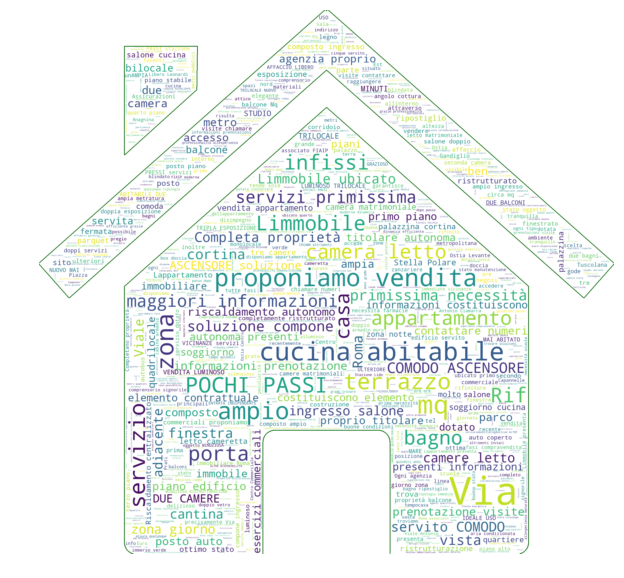

In [31]:
text2 = pd.DataFrame(wc2, columns = ['Second JS Descriptions'])
res2 = " ".join(review for review in text2['Second JS Descriptions'])

print("There are {} words in the combination of all review.".format(len(res2)))

transformed_house_mask2 = np.ndarray((house_mask.shape[0], house_mask.shape[1]), np.int32)

for i in range(len(house_mask)):
    transformed_house_mask2[i] = list(map(fn.transform_format, house_mask[i]))

transformed_house_mask2

wc2 = WordCloud(background_color="white", max_words=1000, mask=transformed_house_mask2,
               stopwords=stop_words, contour_width=3, contour_color='darkgreen')

wc2.generate(res2)

plt.figure(figsize=[20,10])
plt.imshow(wc2, interpolation='bilinear')
plt.axis("off")
plt.show()

#### Third WordCloud

There are 60950 words in the combination of all review.


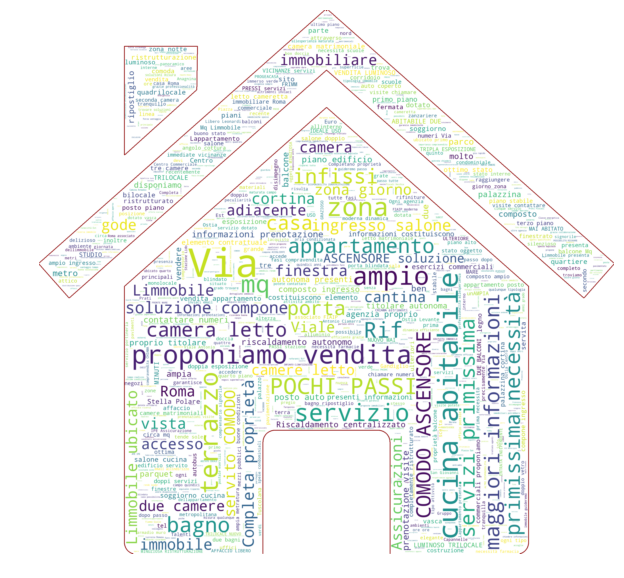

In [32]:
text3 = pd.DataFrame(wc3, columns = ['Third JS Descriptions'])
res3 = " ".join(review for review in text3['Third JS Descriptions'])
print("There are {} words in the combination of all review.".format(len(res3)))

transformed_house_mask3 = np.ndarray((house_mask.shape[0], house_mask.shape[1]), np.int32)

for i in range(len(house_mask)):
    transformed_house_mask3[i] = list(map(fn.transform_format, house_mask[i]))

transformed_house_mask3

wc3 = WordCloud(background_color="white", max_words=1000, mask=transformed_house_mask3,
               stopwords=stop_words, contour_width=3, contour_color='darkred')

wc3.generate(res3)

plt.figure(figsize=[20,10])
plt.imshow(wc3, interpolation='bilinear')
plt.axis("off")
plt.show()

## Hash function

As described in the homework text, we were asked to create hash functions in order to detect duplicates in a given file called "password2.txt". We used different functions but we opted to store them in a separate file called *functions.py*, there you will find all the code we used with an accurate description.

Here you can find the code we have used to go thtrough the txt file and create hashing tables. Due to the size of the document(over 100 millions lines), we decided to scan them in chunks in order to fasten our computational time. For every chunk, we created hash tables(with and without order) using the functions we have defined in *functions.py*. 

After having done that, in different cells we search for duplicates and false positives. Having assumed that our hash function is working properly and for that reason two different string won't have the same hash values, a false positive will happen when two different hash values(corresponding to different strings) will be addressed to the same index. 

We used two different hash functions depending if we had to take into account the order or not. Here are the assumptions we have made:

**Without order**

For every string, we went through all the characters and we converted every character into its unicode code and squared it. After having parsed all the chars, we summed them up and multiplied for a large prime number. This was our hash value and then we computed our hash index by modulating it and saving it into a dictionary(for more informations about the modulating part go and have a look in *functions.py*).

**With order**

Having to take into account the order in which the Char appeared, we could not proceed as we have done for the previous case. We made some little adjustments but the main idea remained the same. For every string, we went through all the characters and we converted every character into its unicode code and squared it. After this we multiplied the code of that char for the sum of the previous chars in order to take into account the position in which the char appeared. The other steps are similar to the Without order procedure.

In [ ]:
idx = 0
for i in pd.read_csv('passwords2.txt', sep=" ", header=None, chunksize = 1000):                     
    ss = []    
    #convert pandas.series to a lsit
    for j in range(len(i)):           
        ss.append(i[[0][0]].tolist())
    #flatten the list
    s = [w for a in ss for w in a]
    fn.hash_without_order(s, idx)
    fn.hash_with_order(s, idx)
    idx += 1   

Due to the size of the file and time constraint we were not able to hash the whole txt file. 
Here you can see the number of duplicates within the chunk of the text file we were able to run. 

Check duplicates and false positives when order **doesn't** matter
'AABA' == 'ABAA'

In [5]:
fn.check_duplicates_falsePositive(0)

2510704 word/s was/were duplicated out of 3248000 rows.
There were 0 false positives


Check duplicates and false positives when order matters
'AABA' != 'ABAA'

In [11]:
fn.check_duplicates_falsePositive(1)

1093641 word/s was/were duplicated out of 1256000 rows.
There were 0 false positives.
